# ***NOTEBOOK 3: SISTEMA DE RECOMENDACION***


# **Carga de los datos**

*   **Librerias**

In [1]:
!pip install google-cloud-storage pandas

In [2]:
!pip install nltk

  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached regex-2024.11.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (40 kB)
Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
Using cached regex-2024.11.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (781 kB)


In [3]:
!pip install sentence-transformers

  Using cached sentence_transformers-3.3.1-py3-none-any.whl.metadata (10 kB)
  Using cached transformers-4.46.3-py3-none-any.whl.metadata (44 kB)
  Using cached torch-2.5.1-cp310-cp310-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached huggingface_hub-0.26.2-py3-none-any.whl.metadata (13 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cus

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import re
from nltk.stem import WordNetLemmatizer

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

*   **Dataset: Recipes**

In [6]:
from google.cloud import storage

# Configura el nombre de tu bucket y archivo
bucket_name = 'mi-bucket-tfg'
file_path = 'datos/df_recipe_aspects.pkl'
local_path = '/tmp/df_recipe_aspects.pkl'

# Conectar a Google Cloud Storage
client = storage.Client()
bucket = client.bucket(bucket_name)
blob = bucket.blob(file_path)
blob.download_to_filename(local_path)

# Cargar el archivo Pickle en un DataFrame
df_recipes = pd.read_pickle(local_path)
df_recipes.head()

,name,description,servings,recipe_id,recipe_grams,recipe_minutes,ingredients_list,ingredients_and_quantities,instructions,keywords,...,fiber_100g,sugar_100g,protein_100g,time_group,avg_rating,review_count,n_ingredients,nutriscore,highlighted_aspects,criticized_aspects
0,Bourbon Chicken,I searched and finally found this recipe on th...,4,45809.0,330.0,35.0,"[boneless chicken breasts, olive oil, garlic c...","[2 lbs boneless chicken breasts, cut into bite...",[1. Editor's Note: Named Bourbon Chicken beca...,"[dinner, chinese, low-carb, chicken, 60-minute...",...,0.09,6.52,15.18,30-40,4.31,2892.0,11,C,"[aabout thick perfection, great thing, good re...",[]
1,Creamy Cajun Chicken Pasta,N'awlin's style of chicken with an updated Alf...,2,39087.0,373.0,25.0,"[boneless skinless chicken breast halves, ling...","[2 boneless skinless chicken breast halves, cu...",[1. Place chicken and Cajun seasoning in a bow...,"[pasta, dinner, cajun, southern, chicken, 30-m...",...,0.67,0.83,10.54,20-30,4.54,1491.0,12,D,"[perfect cooking, true delight, fresh colour, ...",[stuck recipe]
2,"Yes, Virginia There is a Great Meatloaf",Absolutely delicious meatloaf and sauce! Those...,4,54257.0,232.0,80.0,"[ground beef, bread, egg, vidalia onions, tabl...",[1 1/2 lbs ground beef (ground shoulder roast ...,[1. Meatloaf: Combine meat loaf ingredients an...,"[dinner, southern, low-carb, time-to-make, cou...",...,0.17,8.15,15.30,80-90,4.21,1325.0,11,D,"[fond meatloaf, sweet side, straight ketchup, ...",[]
3,Jo Mama's World Famous Spaghetti,My kids will give up a steak dinner for this s...,10,22782.0,285.0,80.0,"[italian sausage, onion, garlic cloves, diced ...","[2 lbs Italian sausage, casings removed (mild ...","[1. In large, heavy stockpot, brown Italian sa...","[dinner, pasta, italian, weeknight, time-to-ma...",...,1.33,4.00,10.46,80-90,4.42,1273.0,16,D,"[great keeper, best sauce, wonderful recipe, g...",[sausage drained]
4,Pancakes,"This is really a great recipe! It is fast, sim...",1,25690.0,407.0,10.0,"[egg, milk, butter, flour, sugar, baking powde...","[1 egg, 3/4 cup milk, 2 tablespoons butter or ...","[1. Beat egg until fluffy., 2. Add milk and me...","[breakfast, 15-minutes-or-less, time-to-make, ...",...,0.10,0.37,0.69,10-20,4.43,1076.0,7,A,"[fantastic recipe, good pancake, good sweet pa...",[]


*   **Dataset: Reviews**

In [7]:
from google.cloud import storage

# Configura el nombre de tu bucket y archivo
bucket_name = 'mi-bucket-tfg'
file_path = 'datos/df_reviews_filtered.pkl'
local_path = '/tmp/df_reviews_filtered.pkl'

# Conectar a Google Cloud Storage
client = storage.Client()
bucket = client.bucket(bucket_name)
blob = bucket.blob(file_path)
blob.download_to_filename(local_path)

# Cargar el archivo Pickle en un DataFrame
df_reviews = pd.read_pickle(local_path)
df_reviews.head()

,review_id,recipe_id,author_id,rating,review,review_date
0,9,4523,2046,2,i think i did something wrong because i could ...,2000
1,14,44,2085,5,An excellent dish.,2000
2,23,4684,2046,5,this is absolutely delicious. i even served i...,2000
3,28,1451,2416,1,Where does the bbq come in,2000
4,55,7762,2369,3,They taste better than they appear.\r\n,2000


# **1. Sistema de Recomendación Basado en Popularidad (Weighted Rating)**

En este análisis, implementamos un sistema de recomendación basado en la popularidad de las recetas. Para ello, utilizamos una métrica conocida como **Weighted Rating (WR)**, que combina la calificación promedio de una receta con el número de reseñas recibidas. El objetivo es dar mayor relevancia a las recetas que no solo tienen buenas calificaciones, sino que también cuentan con un número significativo de reseñas, lo que aporta mayor confianza en la evaluación.

**Fórmula del Weighted Rating (WR)**

La fórmula utilizada para calcular el WR es la siguiente:

$$
WR = \frac{n}{n+m} \cdot \overline{R} + \frac{m}{n+m} \cdot C
$$

Donde:
- $n$: Número de reseñas de la receta (columna `review_count`).
- $\overline{R}$: Calificación promedio de la receta (columna `avg_rating`).
- $m$: Umbral mínimo de reseñas para que una receta sea considerada popular. En este caso, hemos utilizado $m = 100$, lo cual significa que las recetas con menos de 100 reseñas tenderán a acercarse al promedio global.
- $C$: Calificación promedio global de todas las recetas (media de la columna `avg_rating`).

Esta fórmula pondera las calificaciones de las recetas en función del número de reseñas. Las recetas con muchas reseñas tendrán mayor influencia de su calificación promedio, mientras que las recetas con pocas reseñas tenderán a alinearse más con la calificación promedio global $C$.


In [8]:
C = df_recipes['avg_rating'].mean()
m = 1000

df_recipes['WR'] = df_recipes['review_count'] / (df_recipes['review_count'] + m) * df_recipes['avg_rating'] + m / (df_recipes['review_count'] + m) * C
df_recipes = df_recipes.sort_values(ascending=False, by='WR')
df_recipes.head(10)

,name,description,servings,recipe_id,recipe_grams,recipe_minutes,ingredients_list,ingredients_and_quantities,instructions,keywords,...,sugar_100g,protein_100g,time_group,avg_rating,review_count,n_ingredients,nutriscore,highlighted_aspects,criticized_aspects,WR
30,Roasted Asparagus,"I got this recipe from ""Simple Vegetarian Plea...",4,50847.0,119.0,25.0,"[asparagus, olive oil, kosher salt]","[1 lb asparagus, 1 1/2 tablespoons olive oil, ...","[1. Preheat oven to 425°F., 2. Cut off the woo...","[side, dinner, vegetarian, low-carb, low-calor...",...,1.26,2.27,20-30,4.84,452.0,3,C,"[wonderful recipe, wonderful second day, perfe...",[],4.559188
108,Mexican Stack-Up #RSC,"Ready, Set, Cook! Reynolds Wrap Contest Entry....",6,486261.0,351.0,75.0,"[poblano pepper, reynolds wrap foil, olive oil...","[1 poblano pepper, Reynolds Wrap Foil, 2 table...",[1. Preheat broiler to high broil. Set the ra...,"[dinner, low-carb, mexican, time-to-make, cour...",...,0.74,12.42,70-80,4.99,217.0,22,D,"[nice alternative wing, enough amazing making,...",[],4.531710
46,Roasted Cauliflower &amp; 16 Roasted Cloves of...,"I find it totally amazing, that children and m...",6,106251.0,158.0,40.0,"[cauliflower, garlic cloves, fresh rosemary, s...",[1 large cauliflower (trimmed and cut into bit...,"[1. Mix oil, rosemary, salt, pepper and garlic...","[side, vegetarian, low-carb, low-calorie, vega...",...,1.77,2.03,40-50,4.75,357.0,7,C,"[delicious rita, perfect love, excellent flavo...",[wrong temperature],4.515852
7,Kittencal's Moist Cheddar-Garlic Oven Fried Ch...,This is for serious garlic lovers. The chicken...,4,82102.0,185.0,60.0,"[butter, garlic, garlic powder, seasoning salt...","[1/3 cup butter, melted , 2 tablespoons minced...","[1. Preheat oven to 350°F., 2. Butter an 11 x ...","[dinner, chicken, 60-minutes-or-less, time-to-...",...,0.81,18.86,60-70,4.61,862.0,10,D,"[full robust garlic flavor, fine happy meal, f...","[crazy chicken, wrong piece]",4.514544
38,Roasted Green Beans,"A great alternative to fast-food French fries,...",4,133821.0,154.0,25.0,"[green beans, olive oil, kosher salt, fresh gr...","[2 lbs green beans, 1 or 2 tablespoon olive o...","[1. Preheat oven to 400°F., 2. Wash, dry well,...","[side, lactose-free, vegetarian, snack, lunch,...",...,4.81,2.73,20-30,4.73,381.0,4,B,"[great frozen green bean, exciting way, awesom...",[],4.514403
14,My Family's Favorite Sloppy Joes (Pizza Joes),"I've tried many recipes, this is the best. I o...",4,63689.0,250.0,45.0,"[ground beef, celery, onion, tomato sauce, ket...","[1 lb ground beef, 2 or 3 stalks celery, chop...","[1. In a large skillet, brown ground beef, cel...","[dinner, pizza, lunch, 60-minutes-or-less, tim...",...,5.92,9.04,40-50,4.61,726.0,11,C,"[good sloppy joes, great recipe, long deliciou...",[],4.507023
34,Kittencal's Easy and Delicious Ranch-Parmesan ...,"There are plenty versions of this recipe, this...",6,200296.0,190.0,40.0,"[boneless skinless chicken breasts, dry breadc...","[6 boneless skinless chicken breasts, 1 cup dr...",[1. Set oven to 400° degrees (set oven rack to...,"[dinner, 60-minutes-or-less, time-to-make, cou...",...,1.11,15.58,40-50,4.65,426.0,8,D,"[nice crispy, best chicken, good recipe, quick...",[],4.497308
1,Creamy Cajun Chicken Pasta,N'awlin's style of chicken with an updated Alf...,2,39087.0,373.0,25.0,"[boneless skinless chicken breast halves, ling...","[2 boneless skinless chicken breast halves, cu...",[1. Place chicken and Cajun seasoning in a bow...,"[pasta, dinner, cajun, southern, chicken, 30-m...",...,0.83,10.54,20-30,4.54,1491.0,12,D,"[perfect cooking, true delight, fresh colour, ...",[stuck recipe],4.496749
140,Tiny Cinnamon Rolls,Southern Living. My kids adore these tiny litt...,1,25723.0,279.0,42.0,"[refrigerated crescent dinner rolls, sugar, gr...",[1 (8 ounce) package refrigerated crescent din...,"[1. Unroll dough, and separate into 4 rectangl...","[healthy, breakfast, 60-minutes-or-less, time-...",...,1.00,0.39,40-50,4.81,188.0,6,A,"[quick fabulou

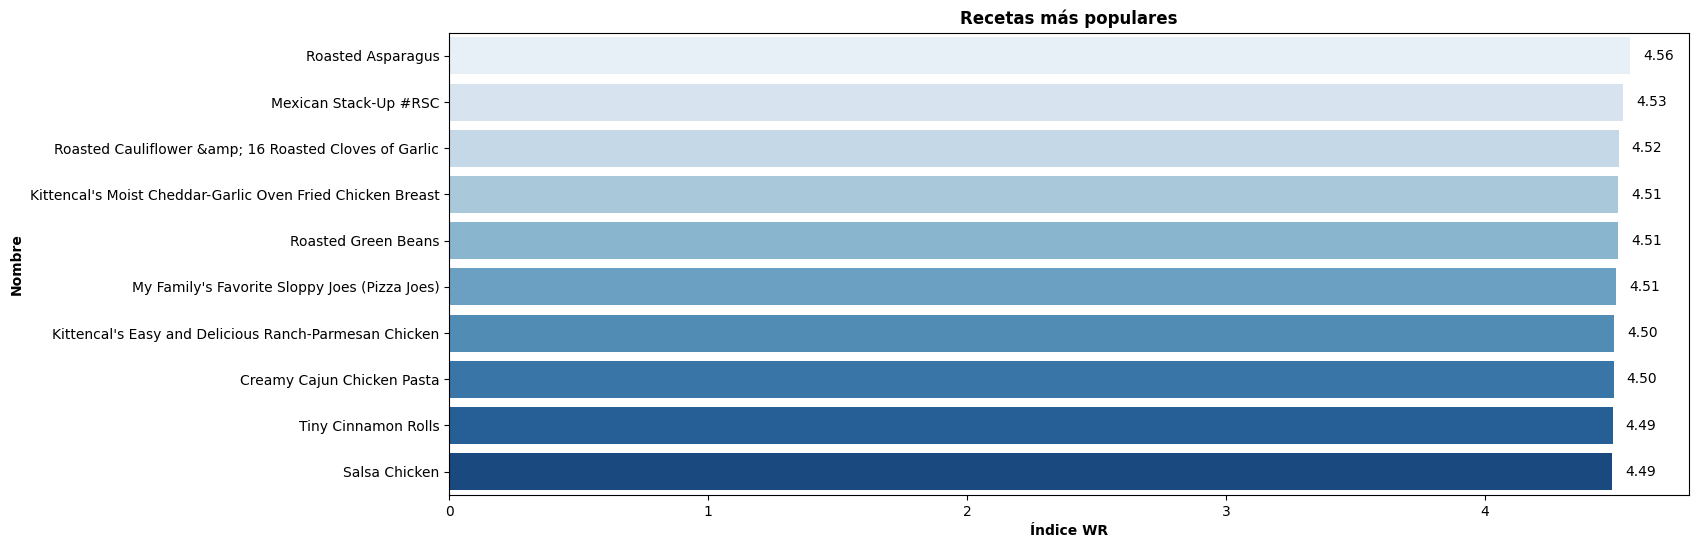

In [9]:
plt.figure(figsize=(16, 6))

ax = sns.barplot(x='WR', y='name', data=df_recipes.head(10), palette='Blues')

for i, bar in enumerate(ax.patches):
    ax.text(
        bar.get_width() + 0.05,
        bar.get_y() + bar.get_height() / 2,
        f'{bar.get_width():.2f}',
        va='center',
        ha='left',
        fontsize=10)

plt.title('Recetas más populares', weight='bold')
plt.xlabel('Índice WR', weight='bold')
plt.ylabel('Nombre', weight='bold')

plt.show()

Segun el `WR` estas son las 10 recetas mas populares a partir del rating promedio y la cantidad de reseñas que obtuvieron.

* Roasted Asparagus (Espárragos Asados)
* Mexican Stack-Up #RSC (Cazuela Mexicana)
* Roasted Cauliflower & 16 Roasted Cloves of Garlic (Coliflor Asada y 16 Dientes de Ajo Asados)
* Roasted Green Beans (Judías Verdes Asadas)
* Kittencal's Moist Cheddar-Garlic Oven Fried Chicken Breast (Pechuga de Pollo Frita al Horno con Cheddar y Ajo Jugosa de Kittencal)
* My Family's Favorite Sloppy Joes (Pizza Joes) (Sloppy Joes Favoritos de Mi Familia)
* Kittencal's Easy and Delicious Ranch-Parmesan Chicken (Pollo Ranch-Parmesano Fácil y Delicioso de Kittencal)
* Creamy Cajun Chicken Pasta (Pasta de Pollo Cajún Cremosa)
* Tiny Cinnamon Rolls (Pequeños Rolls de Canela)
* Salsa Chicken (Pollo a la Salsa)

Una vez desarrollado este enfoque, lo aplicaremos posteriormente en la recomendación basada en filtros. Esto permitirá que el sistema sugiera recetas que cumplan con los criterios establecidos, ordenándolas de mayor a menor popularidad según el puntaje ponderado (WR).

### **Impresion de recetas**

La función `imprimir_recetas` organiza y presenta los detalles de una receta desde un DataFrame. Por cada fila, muestra el nombre, descripción, porciones, peso, Nutriscore, lista de ingredientes con cantidades, e instrucciones paso a paso, separándolas con líneas divisorias para mejorar la claridad visual.

In [10]:
def imprimir_recetas(df):
    for index, row in df.iterrows():
        print(f"\n{row['name']}")
        print(f"↳ {row['description']}")
        print(f"\nServings: {row['servings']}")
        print(f"Recipe Grams: {int(row['recipe_grams'])} g")
        print(f"Preparation Time: {int(row['recipe_minutes'])} minutes")
        print(f"Nutriscore: {row['nutriscore']}")

        # Imprimir los ingredientes
        print(f"\nIngredients and Quantities:")
        for ingredient in row['ingredients_and_quantities']:
            print(f"  - {ingredient}")

        # Imprimir las instrucciones
        print(f"\nInstructions:")
        for instruction in row['instructions']:
            print(f"{instruction}")

        print("\n" + "-"*100)

In [52]:
def imprimir_recetas_con_keywords(df):
    for index, row in df.iterrows():
        print(f"\n{row['name']}")
        print(f"↳ {row['description']}")
        print(f"\nServings: {row['servings']}")
        print(f"Recipe Grams: {int(row['recipe_grams'])} g")
        print(f"Preparation Time: {int(row['recipe_minutes'])} minutes")
        print(f"Nutriscore: {row['nutriscore']}")

        # Imprimir los ingredientes
        print(f"\nIngredients and Quantities:")
        for ingredient in row['ingredients_and_quantities']:
            print(f"  - {ingredient}")

        # Imprimir las instrucciones
        print(f"\nInstructions:")
        for instruction in row['instructions']:
            print(f"{instruction}")
        
        # Imprimir las Keywords
        print(f"\nKeywords:")
        for keyword in row['keywords']:
            print(f"- {keyword}")
        

        print("\n" + "-"*100)

In [64]:
def imprimir_recetas_con_aspectos(df):
    for index, row in df.iterrows():
        print(f"\n{row['name']}")
        print(f"↳ {row['description']}")
        print(f"\nServings: {row['servings']}")
        print(f"Recipe Grams: {int(row['recipe_grams'])} g")
        print(f"Preparation Time: {int(row['recipe_minutes'])} minutes")
        print(f"Nutriscore: {row['nutriscore']}")

        # Imprimir los ingredientes
        print(f"\nIngredients and Quantities:")
        for ingredient in row['ingredients_and_quantities']:
            print(f"  - {ingredient}")

        # Imprimir las instrucciones
        print(f"\nInstructions:")
        for instruction in row['instructions']:
            print(f"{instruction}")
        
        # Imprimir los highlighted_aspects
        print(f"\nAspectos destacados por otros usuarios:")
        for aspecto in row['highlighted_aspects']:
            print(f"- {aspecto}")
            
        # Imprimir los criticized_aspects
        print(f"\nAspectos criticados por otros usuarios:")
        for aspecto in row['criticized_aspects']:
            print(f"- {aspecto}")
        

        print("\n" + "-"*100)

### **Normalizacion de los datos**

Al igual que en el notebook anterior, donde aplicamos técnicas de Procesamiento de Lenguaje Natural (NLP), la normalización del texto es un paso fundamental para generar embeddings de manera efectiva. Este proceso asegura que el texto se transforme en una forma estándar que permita obtener representaciones más precisas y coherentes. Para ello, utilizaremos la siguiente función que realiza las tareas de limpieza y preparación necesarias para optimizar la calidad de los embeddings.
 - Convierte a minúsculas.
 - Elimina caracteres especiales y puntuación.
 - Quita números.
 - Elimina espacios extras.

Se mantienen las stopwords en este caso porque, en contextos como nombres de recetas, estas pueden ser relevantes para preservar el significado. Este proceso asegura que los embeddings capturen de manera efectiva las relaciones y el contexto de las palabras.

In [13]:
def normalizar_texto(texto):
    if isinstance(texto, str):
        # Convertir a minúsculas
        texto = texto.lower()
        # Eliminar números
        texto = re.sub(r'\d+', '', texto)
        # Eliminar caracteres especiales y puntuación (excepto espacios)
        texto = re.sub(r'[^\w\s]', '', texto)
        # Quitar espacios extras
        texto = re.sub(r'\s+', ' ', texto).strip()
        return texto
    elif isinstance(texto, list):
        # Normalizar cada elemento si es una lista
        return [normalizar_texto(item) for item in texto]
    return texto

# **2. Sistema de Recomendación Basados en Contenido**
Los sistemas de recomendación basados en contenido son una técnica de recomendación que sugiere elementos a los usuarios en función de las características específicas de los productos o servicios y el historial de preferencias del usuario. Estos sistemas analizan las propiedades del contenido (como descripciones, categorías, o características técnicas) y utilizan la información del perfil del usuario, como intereses o interacciones previas, para encontrar similitudes entre lo que el usuario ya ha consumido o valorado positivamente y otros elementos disponibles. Su enfoque principal es personalizar la experiencia al identificar elementos similares en función de atributos explícitos, sin depender de las opiniones o interacciones de otros usuarios.Los sistemas de recomendación basados en contenido son una técnica de recomendación que sugiere elementos a los usuarios en función de las características específicas de los productos o servicios y el historial de preferencias del usuario. Estos sistemas analizan las propiedades del contenido (como descripciones, categorías, o características técnicas) y utilizan la información del perfil del usuario, como intereses o interacciones previas, para encontrar similitudes entre lo que el usuario ya ha consumido o valorado positivamente y otros elementos disponibles. Su enfoque principal es personalizar la experiencia al identificar elementos similares en función de atributos explícitos, sin depender de las opiniones o interacciones de otros usuarios.

## **2.1. Busqueda por Receta**

**Paso 1: Normalizacion de los Datos**

In [14]:
# Normalizar la columna
df_recipes['normalized_name'] = df_recipes['name'].apply(normalizar_texto)
df_recipes['normalized_name']

30                                     roasted asparagus
108                                  mexican stackup rsc
46      roasted cauliflower amp roasted cloves of garlic
7      kittencals moist cheddargarlic oven fried chic...
38                                   roasted green beans
                             ...                        
161                                  easy garlic chicken
55                                  general tsos chicken
23                                          poverty meal
254                                carb free cloud bread
25                                 minute vegan pancakes
Name: normalized_name, Length: 50000, dtype: object

**Paso 2: Vectorización de los Nombres de las Recetas**

Este código utiliza el modelo preentrenado `paraphrase-MiniLM-L6-v2` de la biblioteca SentenceTransformer para generar embeddings (representaciones numéricas) de los nombres de las recetas. Este modelo es ideal porque está diseñado para capturar relaciones semánticas y contextuales en textos cortos, como títulos o frases, de manera eficiente. Al transformar el nombre de cada receta en un vector, podemos comparar recetas de manera más flexible, permitiendo búsquedas y recomendaciones basadas en similitud semántica en lugar de coincidencias exactas de palabras. Esto mejora la precisión y relevancia del sistema de recomendación al identificar recetas relacionadas de forma más intuitiva.

In [15]:
# Cargar modelo preentrenado para embeddings
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Generar embeddings para el nombre de cada receta
df_recipes['recipe_name_embeddings'] = df_recipes['normalized_name'].apply(
    lambda x: model.encode(x, convert_to_numpy=True)
)

**Paso 3: Cálculo de Similitud de Coseno**

Este código utiliza la similitud de coseno para recomendar recetas basadas en el nombre ingresado por el usuario. Primero, genera un embedding (representación numérica) del nombre proporcionado en la consulta del usuario utilizando el modelo preentrenado empleado previamente (paraphrase-MiniLM-L6-v2). Luego, calcula la similitud entre este embedding y los embeddings precalculados de los nombres de las recetas utilizando la similitud de coseno. La similitud de coseno es una medida que evalúa qué tan similares son dos vectores en un espacio multidimensional, tomando en cuenta el ángulo entre ellos, independientemente de su magnitud. Esta técnica permite identificar relaciones semánticas entre el nombre consultado y las recetas disponibles, ayudándonos a ordenar y recomendar las recetas más relevantes según la similitud con la consulta del usuario.

In [16]:
def recomendacion_por_receta(recipe_name, df, model, top_n=3, asc_similarity=False):
    # Generar el embedding para la receta ingresada
    query_embedding = model.encode(recipe_name, convert_to_numpy=True)

    # Calcular similitud coseno entre la consulta y cada receta
    df['similarity'] = df['recipe_name_embeddings'].apply(
        lambda x: cosine_similarity([query_embedding], [x])[0][0]
    )

    # Ordenar por similitud primero y por WR como criterio secundario
    recetas_recomendadas = df.sort_values(by=['similarity', 'WR'], ascending=[asc_similarity, False]).head(top_n)

    if recetas_recomendadas.empty:
        print("\n↳ No recipes match your query. Please try different names.")
    else:
        print("\nRECIPES:")
        imprimir_recetas(recetas_recomendadas)

**Paso 4: Prueba del Sistema**

In [17]:
'''recipe_usuario = input("Please enter the name of the recipe: ").strip().lower()
recomendacion_por_receta(recipe_usuario, df_recipes, model)'''

'recipe_usuario = input("Please enter the name of the recipe: ").strip().lower()\nrecomendacion_por_receta(recipe_usuario, df_recipes, model)'

Recetas con mayor similitud de coseno:

In [18]:
recomendacion_por_receta('pancakes', df_recipes, model)


RECIPES:

Pancakes
↳ This recipe comes from my Betty Crocker cookbook. This is the only pancake recipe I will use because they are so light and fluffy.

Servings: 1
Recipe Grams: 415 g
Preparation Time: 10 minutes
Nutriscore: D

Ingredients and Quantities:
  - 1 egg
  - 1 cup all or purpose flour
  - 3/4 cup milk
  - 2 tablespoons vegetable oil
  - 1 tablespoon sugar
  - 1 tablespoon baking powder
  - 1/2 teaspoon salt

Instructions:
1. Beat eggs with whisk until fluffy.
2. Beat in all remaining ingredients until smooth.
3. Heat griddle or pan.
4. Pour about 3 tablespoons of batter in pan and cook until pancake is puffed and dry around the edges.
5. Turn and cook other side until golden brown.

----------------------------------------------------------------------------------------------------

Pancakes
↳ A simple old fashioned pancake recipe. Good with syrup.

Servings: 4
Recipe Grams: 157 g
Preparation Time: 20 minutes
Nutriscore: D

Ingredients and Quantities:
  - 1 1/2 cups all or

Recetas con menor similitud de coseno:

In [19]:
recomendacion_por_receta('pancakes', df_recipes, model, asc_similarity=True)


RECIPES:

Imam Bayildi
↳ A famous Turkish dish, its name means literally 'the Immam fainted' - some say at the deliciousness of the dish, others claim the poor priest was horrified at the amount of oil the dish used! I prefer the first theory!

Servings: 4
Recipe Grams: 486 g
Preparation Time: 35 minutes
Nutriscore: A

Ingredients and Quantities:
  - 4 medium aubergines (eggplants)
  - 3 tablespoons olive oil
  - 1 onion, finely chopped 
  - 2 garlic, cloves crushed 
  - 1 green pepper (capsicum)
  - 1 red pepper (capsicum)
  - parsley, good handful chopped 
  - 3 large tomatoes, blanched, skinned and coarsely chopped 
  - 1/2 teaspoon ground cinnamon
  - black pepper
  - salt
  - 1/2 or 1 teaspoon sugar
  - 1/2 lemon, juice of 

Instructions:
1. Heat oven to 190°C/375°F/Gas 5.
2. Slice each aubergine in half lengthwise.
3. Scoop out the flesh from the aubergines and chop.
4. Blanch the aubergine shells in boiling water for 2 minutes then drain upside down.
5. Heat 3 tbsp of oil in a 

Las recetas con menor similitud de coseno muestran poca relación con el término ingresado, mientras que aquellas con mayor similitud reflejan una mayor afinidad semántica. Esto demuestra que la función está operando de manera efectiva, identificando recetas relevantes basadas en la consulta proporcionada.

## **2.2. Busqueda por Ingredientes**
Para realizar el filtrado de recetas, probaremos dos métodos para determinar cuál ofrece los mejores resultados:

* **Filtrado por coincidencias exactas:** En este enfoque, filtraremos las recetas buscando coincidencias exactas entre los ingredientes listados en la base de datos y el valor ingresado por el usuario. Este método se basa en la simple comparación directa de palabras, asegurando que solo se consideren recetas que contengan exactamente el término especificado.
* **Filtrado basado en embeddings y similitud de coseno:** En este caso, utilizaremos técnicas más avanzadas de Procesamiento de Lenguaje Natural (NLP). Generaremos embeddings para los ingredientes y, mediante la similitud de coseno, identificaremos las recetas cuyos ingredientes sean más similares al término proporcionado por el usuario. Este enfoque permite una búsqueda más flexible y contextual, considerando términos relacionados o cercanos semánticamente al término ingresado.

### **2.2.1. Filtrado por coincidencias exactas**

La función `recomendar_recetas_por_ingrediente` permite filtrar y recomendar recetas que contienen un ingrediente específico. Busca el ingrediente en la lista de ingredientes de cada receta del DataFrame y ordena las recetas por su popularidad (`WR`) para sugerir las cinco mejores. Luego, utiliza la función `imprimir_recetas` para mostrar los detalles de las recetas seleccionadas. En caso contrario devuelve un mensaje de error.

In [20]:
def recomendar_por_ingredientes(ingrediente, df):
    # Tokenizamos el ingrediente ingresado
    ingrediente_tokenizado = set(word_tokenize(ingrediente.lower()))
    
    # Filtrar las recetas que contienen el ingrediente tokenizado
    recetas_filtradas = df[df['ingredients_list'].apply(
        lambda ingredientes: any(set(word_tokenize(i.lower())) & ingrediente_tokenizado for i in ingredientes)
    )]

    # Verificar si hay recetas filtradas
    if recetas_filtradas.empty:
        print("\n↳ There are no recipes for the ingredient you entered. Please make sure it is spelled correctly or try the plural.")
    else:
        # Obtener las 5 recetas más populares basadas en 'WR'
        print("\nRECIPES:")
        recetas_recomendadas = recetas_filtradas.sort_values(by='WR', ascending=False).head(3)

        imprimir_recetas(recetas_recomendadas)

In [21]:
'''ingrediente_usuario = input("Please enter one or more ingredients, separated by commas: ")
recomendar_por_ingredientes(ingrediente_usuario, df_recipes)'''

'ingrediente_usuario = input("Please enter one or more ingredients, separated by commas: ")\nrecomendar_por_ingredientes(ingrediente_usuario, df_recipes)'

In [22]:
recomendar_por_ingredientes('cherries, chocolate', df_recipes)


RECIPES:

No-Bake Rice Krispies Peanut Butter Granola Bars (Lower-Fat)
↳ This is a delicious lower fat bar if using reduced-fat peanut butter, these are perfect for kid's lunch boxes, feel free to add in some chopped nuts or sunflower seeds or coconut in place of the raisins,

Servings: 1
Recipe Grams: 572 g
Preparation Time: 22 minutes
Nutriscore: A

Ingredients and Quantities:
  - 1 1/2 cups Rice Krispies (for a firmer bar increase up to 2 cups)
  - 1 1/2 cups quick or cooking oats
  - 1/2 cup brown sugar, packed 
  - 1/2 cup light corn syrup or 1/2 cup honey
  - 1/2 cup reduced or fat peanut butter (or can use regular peanut butter)
  - 1 teaspoon vanilla
  - 1/2 cup dark raisin (or can use either 1/2 cup chopped nuts or 1/2 cup seeds or 1/2 cup coconut)
  - 1/3 cup mini chocolate chip (to prevent melting refrigerate or freeze the chocolate chips before mixing in)

Instructions:
1. lightly grease 11 x 7-inch, can use a 13 x 9-inch baking dish but you will have a thinner bar.
2. In 

### **2.2.2. Filtrado basado en embeddings y similitud de coseno**

**Paso 1: Normalizacion de los Datos**

Los datos de esta variable se encuentran en formato de lista y, en su mayoría, en minúsculas. Sin embargo, para garantizar la consistencia y evitar posibles errores causados por símbolos o palabras con mayúsculas, procederemos a normalizar los datos. Este paso asegura que todos los elementos estén en un formato uniforme.

In [23]:
# Normalizar la columna
df_recipes['normalized_ingredients_list'] = df_recipes['ingredients_list'].apply(normalizar_texto)
df_recipes[['ingredients_list', 'normalized_ingredients_list']]

,ingredients_list,normalized_ingredients_list
30,"[asparagus, olive oil, kosher salt]","[asparagus, olive oil, kosher salt]"
108,"[poblano pepper, reynolds wrap foil, olive oil...","[poblano pepper, reynolds wrap foil, olive oil..."
46,"[cauliflower, garlic cloves, fresh rosemary, s...","[cauliflower, garlic cloves, fresh rosemary, s..."
7,"[butter, garlic, garlic powder, seasoning salt...","[butter, garlic, garlic powder, seasoning salt..."
38,"[green beans, olive oil, kosher salt, fresh gr...","[green beans, olive oil, kosher salt, fresh gr..."
...,...,...
161,"[boneless skinless chicken breasts, garlic clo...","[boneless skinless chicken breasts, garlic clo..."
55,"[boneless skinless chicken breasts, green onio...","[boneless skinless chicken breasts, green onio..."
23,"[onion, garlic cloves, olive oil, ground beef,...","[onion, garlic cloves, olive oil, ground beef,..."
254,"[eggs, whole milk cottage cheese, cream of tar...","[eggs, whole milk cottage cheese, cream of tar..."


**Paso 2: Vectorizacion de los Ingredientes**

In [24]:
# Generar embeddings para la lista de ingredientes en cada receta
df_recipes['ingredients_embeddings'] = df_recipes['normalized_ingredients_list'].apply(
    lambda x: model.encode(' '.join(map(str, x)), convert_to_numpy=True) if x else None
)

**Paso 3: Calculo de Similitud de Coseno**

In [25]:
def recomendacion_por_ingredientes_embeddings(ingredientes, df, model, top_n=3, asc_similarity=False):
    # Generar el embedding para los ingredientes ingresados
    query_embedding = model.encode(' '.join(ingredientes), convert_to_numpy=True)

    # Calcular similitud coseno entre la consulta y cada receta
    df['similarity'] = df['ingredients_embeddings'].apply(
        lambda x: cosine_similarity([query_embedding], [x])[0][0] if x is not None else 0
    )

    # Ordenar por similitud de coseno primero y luego por WR
    recetas_recomendadas = df.sort_values(by=['similarity', 'WR'], ascending=[asc_similarity, False]).head(top_n)

    if recetas_recomendadas.empty:
        print("\n↳ No recipes match your query. Please try different ingredients.")
    else:
        print("\nRECIPES:")
        imprimir_recetas(recetas_recomendadas)

**Paso 4: Prueba del Sistema**

In [26]:
'''# Entrada del usuario
ingredientes_usuario = input("Please enter ingredients separated by commas: ")
ingredientes = [ingrediente.strip().lower() for ingrediente in ingredientes_usuario.split(',') if ingrediente.strip()]
recomendacion_por_ingredientes_embeddings(ingredientes, df_recipes, model)'''

'# Entrada del usuario\ningredientes_usuario = input("Please enter ingredients separated by commas: ")\ningredientes = [ingrediente.strip().lower() for ingrediente in ingredientes_usuario.split(\',\') if ingrediente.strip()]\nrecomendacion_por_ingredientes_embeddings(ingredientes, df_recipes, model)'

Recetas con mayor similitud de coseno:

In [27]:
# Entrada del usuario
ingredientes_usuario = 'cherries, chocolate'
ingredientes = [ingrediente.strip().lower() for ingrediente in ingredientes_usuario.split(',') if ingrediente.strip()]
recomendacion_por_ingredientes_embeddings(ingredientes, df_recipes, model)


RECIPES:

Cherry Pom Poms (Truffles)
↳ These are an essential for the truffle plate at Christmas. They take minutes to make and look great. Dipping in dark chocolate and then drizzling white chocolate over the top looks divine. You could also use red/green sprinkles for that festive touch.

Servings: 1
Recipe Grams: 542 g
Preparation Time: 20 minutes
Nutriscore: C

Ingredients and Quantities:
  - 50 g red glace cherries
  - 1/3 cup condensed milk
  - 2 cups coconut
  - 2 teaspoons cherry flavored liqueur or 2 teaspoons cherry extract
  - 220 g dark chocolate or 220 g chocolate, of choice 

Instructions:
1. Process the first 4 ingredients in a food processor until combined. Refrigerate for approx 30 minutes.
2. Melt chocolate in a heavy pot over low heat or in a microwave; remove from heat.
3. Place cold truffle on skewer or dipping fork, and swirl in chocolate to coat or dip 1/2 only of the truffle in the chocolate mixture.
4. Place on wax or parchment paper to set.

-----------------

Recetas con menor similitud de coseno:

In [28]:
# Entrada del usuario
ingredientes_usuario = 'cherries, chocolate'
ingredientes = [ingrediente.strip().lower() for ingrediente in ingredientes_usuario.split(',') if ingrediente.strip()]
recomendacion_por_ingredientes_embeddings(ingredientes, df_recipes, model, asc_similarity=True)


RECIPES:

Molukhia - Jews Mallow Soup
↳ This is a very common dish through out the middle east known as molukhia in Arabic, but its technical term is jews mallow. Egyptians are famed for their molukhia. Its picked during harvest time and either dried or frozen, so that it may be enjoyed through out the year. Because this is typically grown in the middle east,although there are a few farms that do grow this in the U.S., its readily available in most middle eastern stores either in frozen or dry form. My recipe is based on my frozen version. Recipes will vary throught the middle east, depending on region. Molukhia is made a couple of ways, but this is the more common. Molukhia is traditionally enjoyed with a side of rice and a lemon wedge.Try Egyptian Condiment (Daqua) #107277, to kick it up a notch.

Servings: 6
Recipe Grams: 191 g
Preparation Time: 35 minutes
Nutriscore: C

Ingredients and Quantities:
  - 4  or 5 cups chicken broth
  - 4 pieces chicken
  - 2 (14 ounce) packages frozen

Después de probar y comparar ambos modelos utilizando diferentes ingredientes, como en el caso del ejemplo con cherries y chocolate, se observó que el modelo basado en filtrado por embeddings y similitud de coseno produjo resultados superiores. Esto es lógico, ya que este enfoque captura mejor las relaciones semánticas entre palabras y conceptos, permitiendo identificar similitudes contextuales más precisas que los métodos tradicionales. Después de probar y comparar ambos modelos utilizando diferentes ingredientes, como en el caso de los ejemplos con cherries y chocolate, se observó que el modelo basado en filtrado por embeddings y similitud de coseno produjo resultados superiores. Esto es lógico, ya que este enfoque captura mejor las relaciones semánticas entre palabras y conceptos, permitiendo identificar similitudes contextuales más precisas que los métodos tradicionales. Además, el modelo basado en coincidencias exactas obliga al usuario a ingresar la palabra exactamente como está registrada, sin considerar que el ingrediente podría ser el mismo pero estar escrito en plural en la receta y en singular en el input, o viceversa. Tampoco contempla posibles errores de redacción, ya sea en la receta o en la entrada proporcionada por el usuario, lo que limita su flexibilidad y precisión. Es por ello que para el MVP optamos por quedarnos con el segundo.

## **2.3. Busqueda por Keywords**
De manera similar a lo realizado con los ingredientes, convertiremos las keywords en embeddings para llevar a cabo la búsqueda basándonos en la similitud de coseno.

**Paso 1: Normalizacion de los Datos**

En este caso, las keywords también ya parecen estar normalizadas, ya que están todas en minúsculas. Sin embargo, no aplicaremos la función de normalización previamente creada, ya que esta elimina valores numéricos, y algunas keywords contienen tiempos de preparación que no deben ser eliminados. Por esta razón, utilizaremos una función similar que preserve los valores numéricos, asegurando que la información relevante se mantenga intacta. Además, como en algunas palabras hay guiones, como por ejemplo en low-calorie, vamos a reemplazar los guiones por espacios.

In [29]:
def normalizar_keywords(texto):
    if isinstance(texto, str):
        # Convertir a minúsculas
        texto = texto.lower()
        # Reemplazar los guiones por espacios
        texto = texto.replace('-', ' ')
        # Eliminar caracteres especiales y puntuación (excepto espacios)
        texto = re.sub(r'[^\w\s]', '', texto)
        # Quitar espacios extras
        texto = re.sub(r'\s+', ' ', texto).strip()
        return texto
    elif isinstance(texto, list):
        # Normalizar cada elemento si es una lista
        return [normalizar_keywords(item) for item in texto]
    return texto

In [30]:
# Normalizar la columna
df_recipes['normalized_keywords'] = df_recipes['keywords'].apply(normalizar_keywords)
df_recipes[['keywords', 'normalized_keywords']]

,keywords,normalized_keywords
30,"[side, dinner, vegetarian, low-carb, low-calor...","[side, dinner, vegetarian, low carb, low calor..."
108,"[dinner, low-carb, mexican, time-to-make, cour...","[dinner, low carb, mexican, time to make, cour..."
46,"[side, vegetarian, low-carb, low-calorie, vega...","[side, vegetarian, low carb, low calorie, vega..."
7,"[dinner, chicken, 60-minutes-or-less, time-to-...","[dinner, chicken, 60 minutes or less, time to ..."
38,"[side, lactose-free, vegetarian, snack, lunch,...","[side, lactose free, vegetarian, snack, lunch,..."
...,...,...
161,"[dinner, healthy, chicken, low-sodium, 30-minu...","[dinner, healthy, chicken, low sodium, 30 minu..."
55,"[dinner, chicken, 60-minutes-or-less, time-to-...","[dinner, chicken, 60 minutes or less, time to ..."
23,"[dinner, low-calorie, low-sodium, 30-minutes-o...","[dinner, low calorie, low sodium, 30 minutes o..."
254,"[bread, carb-free, gluten-free, 60-minutes-or-...","[bread, carb free, gluten free, 60 minutes or ..."


**Paso 2: Vectorizacion de las Keywords**

Como el modelo lo cargamos previamente, no es necesario volver a instanciarlo.

In [31]:
# Crear embeddings para las keywords de cada receta
df_recipes['keywords_embeddings'] = df_recipes['normalized_keywords'].apply(
    lambda x: model.encode(' '.join(map(str, x)), convert_to_numpy=True)
)

**Paso 3: Calculo de Similitud de Coseno:**

In [53]:
def recomendacion_por_keywords(keywords, df, model, top_n=3, asc_similarity=False):
    # Generar el embedding para las keywords ingresadas
    query_embedding = model.encode(' '.join(keywords), convert_to_numpy=True)
    
    df['similarity'] = df['keywords_embeddings'].apply(
        lambda x: cosine_similarity([query_embedding], [x])[0][0]
    )

    # Ordenar por similitud de coseno primero y luego por WR
    recetas_recomendadas = df.sort_values(by=['similarity', 'WR'], ascending=[asc_similarity, False]).head(top_n)
    
    # Verificar si hay recetas recomendadas
    if recetas_recomendadas.empty:
        print("\n↳ No recipes match your query. Please try different keywords.")
    else:
        print("\nRECIPES:")
        imprimir_recetas_con_keywords(recetas_recomendadas)

**Paso 4: Prueba del Sistema**

In [54]:
'''keywords_usuario = input("Please enter keywords separated by commas: ")
keywords = [keyword.strip().lower() for keyword in keywords_usuario.split(',') if keyword.strip()]
recomendacion_por_keywords(keywords, df_recipes, model)'''

'keywords_usuario = input("Please enter keywords separated by commas: ")\nkeywords = [keyword.strip().lower() for keyword in keywords_usuario.split(\',\') if keyword.strip()]\nrecomendacion_por_keywords(keywords, df_recipes, model)'

Recetas con mayor similitud de coseno:

In [55]:
keywords_usuario = 'easy, diet'
keywords = [keyword.strip().lower() for keyword in keywords_usuario.split(',') if keyword.strip()]
recomendacion_por_keywords(keywords, df_recipes, model)


RECIPES:

High Fiber Salad
↳ A while back I tried hearts of palm and decided that I really loved it. So I decided to try a recipe with it, when some one told me that it can go well with anything. So I put this one together. I also used frozen corn here because I had plenty in the freezer, and didn't think I needed to go out and buy canned corn. If you do decide to use canned corn, make sure it is plain, and not creamed or flavoured with anything, as it will change the taste and/or texture of the recipe.

Servings: 8
Recipe Grams: 199 g
Preparation Time: 12 minutes
Nutriscore: B

Ingredients and Quantities:
  - 1 (598 ml) can hearts of palm, diced 
  - 1 (19 ounce) can chickpeas
  - 2 cups corn, frozen 
  - 1 large avocado, diced 
  - 4 green onions
  - 1/3 cup olive, chopped 
  - 1 tablespoon lemon juice
  - 2 tablespoons olive oil
  - 1/2 teaspoon salt
  - 1 teaspoon black pepper

Instructions:
1. Put the first 6 ingredients in a bowl and mix.
2. Add the next four ingredients and mix

Recetas con menor similitud de coseno:

In [56]:
keywords_usuario = 'easy, diet'
keywords = [keyword.strip().lower() for keyword in keywords_usuario.split(',') if keyword.strip()]
recomendacion_por_keywords(keywords, df_recipes, model, asc_similarity=True)


RECIPES:

Emeril Lagasse's Moroccan Mint Tea
↳ Recipe from  the foodnetwork.com.

Servings: 4
Recipe Grams: 249 g
Preparation Time: 20 minutes
Nutriscore: B

Ingredients and Quantities:
  - 4 teaspoons green tea leaves or 4 teaspoons moroccan tea
  - 24 fresh spearmint, plus more for garnish 
  - 4  or 5 tablespoons sugar (to taste)
  - 1 quart boiling water

Instructions:
1. Bring a kettle of water to a boil. Add boiling water to a teapot that holds about 4 cups water, and swirl to warm. Discard the water and add the tea, 24 mint leaves, and sugar to the teapot. Pour the quart of boiling water into the teapot and swirl once or twice to dissolve the sugar. Allow the tea to steep for 5 minutes.
2. Pour the tea through a strainer into small decorative Moroccan glasses or teacups. Garnish each with several fresh mint leaves.

Keywords:
- moroccan
- 

----------------------------------------------------------------------------------------------------

Iron Chef Chinese - Chef Chen's Mapo 

Al igual que con los nombres de las recetas, se puede visualizar que las recetas con mayor similitud de coseno tienen relación con los terminos ingresados, mientras que las que menor similitud de coseno tienen, mas alejado se encuentra de lo ingresado. Esto prueba que el sistema funciona correctamente.

## **2.4. Busqueda por Opiniones de otros Usuarios**
 
De manera similar a lo realizado con los dos atributos anteriores, transformaremos los aspectos destacados obtenidos en el notebook 2 a partir de las reseñas de los usuarios en embeddings. Esto nos permitirá realizar la búsqueda utilizando la similitud de coseno como métrica principal.

**Paso 1: Normalizacion de los Datos**

In [57]:
# Normalizar la columna
df_recipes['normalized_highlighted_aspects'] = df_recipes['highlighted_aspects'].apply(normalizar_texto)
df_recipes[['highlighted_aspects', 'normalized_highlighted_aspects']]

,highlighted_aspects,normalized_highlighted_aspects
30,"[wonderful recipe, wonderful second day, perfe...","[wonderful recipe, wonderful second day, perfe..."
108,"[nice alternative wing, enough amazing making,...","[nice alternative wing, enough amazing making,..."
46,"[delicious rita, perfect love, excellent flavo...","[delicious rita, perfect love, excellent flavo..."
7,"[full robust garlic flavor, fine happy meal, f...","[full robust garlic flavor, fine happy meal, f..."
38,"[great frozen green bean, exciting way, awesom...","[great frozen green bean, exciting way, awesom..."
...,...,...
161,"[easier lining, nice garlic sweet recipe, easy...","[easier lining, nice garlic sweet recipe, easy..."
55,"[favorite chinese restaurant, easy recipe, exc...","[favorite chinese restaurant, easy recipe, exc..."
23,"[wonderful recipe, fast easy love, great recip...","[wonderful recipe, fast easy love, great recip..."
254,"[great work, sweet hubby, sweet bread, great r...","[great work, sweet hubby, sweet bread, great r..."


**Paso 1: Vectorizacion de las Opiniones**

In [58]:
# Crear embeddings para los aspectos destacados de cada receta
df_recipes['aspects_embeddings'] = df_recipes['normalized_highlighted_aspects'].apply(
    lambda x: model.encode(' '.join(map(str, x)), convert_to_numpy=True)
)

**Paso 2: Calculo de Similitud de Coseno**

In [65]:
def recomendacion_por_opiniones(aspects, df, model, top_n=3, asc_similarity=False):
    # Verificar si se ingresaron aspectos
    if not aspects:
        print("\n↳ No aspects entered. Please provide at least one aspect.")
        return

    # Generar el embedding para los aspectos ingresados
    query_embedding = model.encode(' '.join(aspects), convert_to_numpy=True)

    df['similarity'] = df['aspects_embeddings'].apply(
        lambda x: cosine_similarity([query_embedding], [x])[0][0]
    )

    # Ordenar por similitud de coseno primero y luego por WR
    recetas_recomendadas = df.sort_values(by=['similarity', 'WR'], ascending=[asc_similarity, False]).head(top_n)

    # Mostrar los resultados
    if recetas_recomendadas.empty:
        print("\n↳ No recipes match your query. Please try different aspects.")
    else:
        print("\nRECIPES:")
        imprimir_recetas_con_aspectos(recetas_recomendadas)

**Paso 3: Prueba del Sistema**

In [66]:
'''aspects_usuario = input("Please enter relevant aspects separated by commas: ")
aspects = [aspect.strip().lower() for aspect in aspects_usuario.split(',') if aspect.strip()]
recomendacion_por_opiniones(aspects, df_recipes, model)'''

'aspects_usuario = input("Please enter relevant aspects separated by commas: ")\naspects = [aspect.strip().lower() for aspect in aspects_usuario.split(\',\') if aspect.strip()]\nrecomendacion_por_opiniones(aspects, df_recipes, model)'

Recetas con mayor similitud de coseno:

In [67]:
aspects_usuario = 'amazing flavor'
aspects = [aspect.strip().lower() for aspect in aspects_usuario.split(',') if aspect.strip()]
recomendacion_por_opiniones(aspects, df_recipes, model)


RECIPES:

Asparagus Spears With Egg
↳ I was not an Asparagus Lover until I tried this French Renaissance recipe! It is simple to make with ingredients on hand and adds a bit of change to fresh asparagus! I have also added crumbled bacon to jazz it up!

Servings: 4
Recipe Grams: 291 g
Preparation Time: 20 minutes
Nutriscore: B

Ingredients and Quantities:
  - 2 lbs fresh green asparagus
  - 2 tablespoons butter
  - 4 eggs (at room temp, important)
  - 1/4 cup finely shredded cheese (your favorite flavor)

Instructions:
1. Cut off each asparagus spear 2 3/4 inches from the end of each tip. Keep the stalks for another use.
2. Cook the asparagus tips for 7 minutes in boiling salted water and then drain. Discard the water and return the asparagus to the saucepan; add the butter and roll the tips around in it.
3. Bring some water to a boil in another saucepan and put in the eggs. Boil for 5 minutes, refresh under running water. Shell the eggs.
4. Divide the asparagus tips between 4 plates. 

Recetas con menor similitud de coseno:

In [68]:
aspects_usuario = 'amazing flavor'
aspects = [aspect.strip().lower() for aspect in aspects_usuario.split(',') if aspect.strip()]
recomendacion_por_opiniones(aspects, df_recipes, model, asc_similarity=True)


RECIPES:

Taco Burgers
↳ These are always fun to make. The kids enjoy helping and really enjoy eating these.

Servings: 8
Recipe Grams: 160 g
Preparation Time: 20 minutes
Nutriscore: C

Ingredients and Quantities:
  - 1 lb ground beef
  - 1 (16 ounce) can diced tomatoes, undrained 
  - 1 tablespoon chili powder
  - 1 tablespoon Worcestershire sauce
  - 1 teaspoon garlic salt
  - 1/2 teaspoon onion powder
  - 1/4 teaspoon dry mustard
  - 1/4 teaspoon pepper
  - lettuce leaf
  - 8 hamburger buns
  - 1 cup shredded Velveeta cheese

Instructions:
1. Brown beef in a large skillet over medium heat; drain.
2. Stir in tomatoes and next 7 ingredients; bring to a boil.
3. Reduce heat, simmer 5-10 minutes.
4. Place lettuce on bottom halves of buns.
5. Spoon beef mixture onto lettuce, sprinkle with cheese.
6. Top with remaining bun halves.

Aspectos destacados por otros usuarios:
- better rule
- easy budget

Aspectos criticados por otros usuarios:

------------------------------------------------

Viendo los resultados se evidencia por tercera vez que la similitud de coseno sirve como metodo para obtener las recetas deseadas con respecto al imput de usuario.

Ya que los embeddings tardan mucho en crearse, guardemos los datos en un csv para poder ejecutar mas rapido el mvp en el proximo notebook.

In [69]:
df_recipes.head()

,name,description,servings,recipe_id,recipe_grams,recipe_minutes,ingredients_list,ingredients_and_quantities,instructions,keywords,...,WR,normalized_name,recipe_name_embeddings,similarity,normalized_ingredients_list,ingredients_embeddings,normalized_keywords,keywords_embeddings,normalized_highlighted_aspects,aspects_embeddings
30,Roasted Asparagus,"I got this recipe from ""Simple Vegetarian Plea...",4,50847.0,119.0,25.0,"[asparagus, olive oil, kosher salt]","[1 lb asparagus, 1 1/2 tablespoons olive oil, ...","[1. Preheat oven to 425°F., 2. Cut off the woo...","[side, dinner, vegetarian, low-carb, low-calor...",...,4.559188,roasted asparagus,"[0.70774525, 0.17281596, -0.53876466, 0.269132...",0.394230,"[asparagus, olive oil, kosher salt]","[0.068096995, -0.039195217, -0.66528445, -0.07...","[side, dinner, vegetarian, low carb, low calor...","[0.3077394, 0.32426354, 0.0824065, 0.06405778,...","[wonderful recipe, wonderful second day, perfe...","[-0.20602725, 0.14390379, 0.14365907, -0.11389..."
108,Mexican Stack-Up #RSC,"Ready, Set, Cook! Reynolds Wrap Contest Entry....",6,486261.0,351.0,75.0,"[poblano pepper, reynolds wrap foil, olive oil...","[1 poblano pepper, Reynolds Wrap Foil, 2 table...",[1. Preheat broiler to high broil. Set the ra...,"[dinner, low-carb, mexican, time-to-make, cour...",...,4.531710,mexican stackup rsc,"[-0.7105343, -0.46382508, -0.65078366, 0.13243...",0.507026,"[poblano pepper, reynolds wrap foil, olive oil...","[-0.6319319, -0.24501374, -0.21909977, 0.15086...","[dinner, low carb, mexican, time to make, cour...","[0.27554333, 0.054395784, -0.22202574, 0.00325...","[nice alternative wing, enough amazing making,...","[-0.3275181, -0.072583556, -0.08541173, -0.266..."
46,Roasted Cauliflower &amp; 16 Roasted Cloves of...,"I find it totally amazing, that children and m...",6,106251.0,158.0,40.0,"[cauliflower, garlic cloves, fresh rosemary, s...",[1 large cauliflower (trimmed and cut into bit...,"[1. Mix oil, rosemary, salt, pepper and garlic...","[side, vegetarian, low-carb, low-calorie, vega...",...,4.515852,roasted cauliflower amp roasted cloves of garlic,"[0.12248431, -0.42801306, -0.38706228, -0.1775...",0.520282,"[cauliflower, garlic cloves, fresh rosemary, s...","[-0.2948644, -0.7789556, -0.25072205, -0.25720...","[side, vegetarian, low carb, low calorie, vega...","[0.2790315, 0.1937376, 0.12796554, 0.001535448...","[delicious rita, perfect love, excellent flavo...","[-0.43774918, -0.24240962, 0.28488114, -0.1198..."
7,Kittencal's Moist Cheddar-Garlic Oven Fried Ch...,This is for serious garlic lovers. The chicken...,4,82102.0,185.0,60.0,"[butter, garlic, garlic powder, seasoning salt...","[1/3 cup butter, melted , 2 tablespoons minced...","[1. Preheat oven to 350°F., 2. Butter an 11 x ...","[dinner, chicken, 60-minutes-or-less, time-to-...",...,4.514544,kittencals moist cheddargarlic oven fried chic...,"[0.004746352, -0.12346557, -0.16879883, 0.1019...",0.428067,"[butter, garlic, garlic powder, seasoning salt...","[-0.5912476, 0.18889797, -0.24024855, -0.00016...","[dinner, chicken, 60 minutes or less, time to ...","[0.10633341, -0.2303488, 0.035587464, -0.31038...","[full robust garlic flavor, fine happy meal, f...","[-0.31652376, 0.08892343, -0.16739975, -0.1637..."
38,Roasted Green Beans,"A great alternative to fast-food French fries,...",4,133821.0,154.0,25.0,"[green beans, olive oil, kosher salt, fresh gr...","[2 lbs green beans, 1 or 2 tablespoon olive o...","[1. Preheat oven to 400°F., 2. Wash, dry well,...","[side, lactose-free, vegetarian, snack, lunch,...",...,4.514403,roasted green beans,"[-0.07211356, 0.03044193, -0.5078084, 0.067886...",0.562420,"[green beans, olive oil, kosher salt, fresh gr...","[-0.4692881, -0.05639726, -0.6351077, -0.14723...","[side, lactose free, vegetarian, snack, lunch,...","[0.18054648, 0.15735793, -0.1573779, 0.0844852...","[great frozen green bean, exciting way, awesom...","[-0.7283577, 0.58083975, -0.41203198, -0.07102..."


In [70]:
bucket_name = 'mi-bucket-tfg'
pickle_file_path = 'df_recipes_embeddings.pkl'

df_recipes.to_pickle(pickle_file_path)

# Conectar con el cliente de Google Cloud Storage
client = storage.Client()
bucket = client.bucket(bucket_name)
blob = bucket.blob('datos/df_recipes_embeddings.pkl')

# Subir el archivo pickle al bucket
blob.upload_from_filename(pickle_file_path)

print(f'El archivo pickle ha sido subido exitosamente al bucket {bucket_name}')

El archivo pickle ha sido subido exitosamente al bucket mi-bucket-tfg


## **2.5. Busqueda por Filtros**
En el sistema de recomendación de recetas, las funciones de filtros son herramientas clave que permiten a los usuarios personalizar su búsqueda según ciertos criterios, mejorando su experiencia al encontrar recetas que se ajusten a sus preferencias específicas. A continuación.

### **2.5.1. Busqueda por Tiempo de Preparación**
Permite al usuario buscar recetas que puedan prepararse en un tiempo máximo determinado, ideal para quienes tienen horarios ajustados o desean preparar algo rápidamente.

In [71]:
def filtrar_recetas_por_tiempo(df, tiempo_maximo, top_n=3):
    try:
        # Filtrar las recetas que tengan un tiempo de preparación menor o igual al tiempo máximo
        recetas_filtradas = df[df['recipe_minutes'] <= tiempo_maximo]
        
        # Verificar si hay recetas que cumplan con la condición
        if recetas_filtradas.empty:
            print("\n↳ No recipes match your maximum preparation time.")
        else:
            # Ordenar las recetas filtradas por 'WR' (de mayor a menor)
            recetas_ordenadas = recetas_filtradas.sort_values(by='WR', ascending=False)
            print(f"\nFound {len(recetas_ordenadas)} recipes that meet your criteria.")
            
            # Llamar a la función imprimir_recetas para mostrar las primeras top_n recetas ordenadas
            return imprimir_recetas(recetas_ordenadas.head(top_n))
    except ValueError:
        print("Please enter a valid number for the maximum preparation time.")

In [72]:
'''tiempo_maximo = int(input("Enter the maximum preparation time in minutes: "))       
filtrar_recetas_por_tiempo(df_recipes, tiempo_maximo)'''

'tiempo_maximo = int(input("Enter the maximum preparation time in minutes: "))       \nfiltrar_recetas_por_tiempo(df_recipes, tiempo_maximo)'

In [73]:
tiempo_maximo = 40       
filtrar_recetas_por_tiempo(df_recipes, tiempo_maximo)


Found 29015 recipes that meet your criteria.

Roasted Asparagus
↳ I got this recipe from "Simple Vegetarian Pleasures" by Jeanne Lemlin. I LOVE asparagus and am always on the lookout for new ways to make it. This is such an easy and elegant way to serve it.  The asparagus gets a slightly nutty flavor after roasting, which makes it even more yummy.

Servings: 4
Recipe Grams: 119 g
Preparation Time: 25 minutes
Nutriscore: C

Ingredients and Quantities:
  - 1 lb asparagus
  - 1 1/2 tablespoons olive oil
  - 1/2 teaspoon kosher salt (or 1/4 teaspoon regular table salt)

Instructions:
1. Preheat oven to 425°F.
2. Cut off the woody bottom part of the asparagus spears and discard.
3. With a vegetable peeler, peel off the skin on the bottom 2-3 inches of the spears (this keeps the asparagus from being all "stringy" and if you eat asparagus you know what I mean by that).
4. Place asparagus on foil-lined baking sheet and drizzle with olive oil.
5. Sprinkle with salt.
6. With your hands, roll th

### **2.5.2. Busqueda por Cantidad de Porciones**
Ayuda al usuario a encontrar recetas que produzcan un número mínimo de porciones, útil para quienes buscan alimentar a una cantidad específica de personas.

In [74]:
def filtrar_recetas_por_porciones(df, min_porciones, top_n=3):
    try:
        # Filtrar las recetas que tengan un número de porciones mayor o igual al minimo especificado
        recetas_filtradas = df[df['servings'] >= min_porciones]
        
        # Verificar si hay recetas que cumplan con la condición
        if recetas_filtradas.empty:
            print("\n↳ No recipes match your minimum servings criteria.")
        else:
            # Ordenar las recetas filtradas por 'WR' (de mayor a menor)
            recetas_ordenadas = recetas_filtradas.sort_values(by=['servings', 'WR'], ascending=[True, False])
            print(f"\nFound {len(recetas_ordenadas)} recipes that meet your criteria.")
            
            # Llamar a la función imprimir_recetas para mostrar las primeras top_n recetas ordenadas
            return imprimir_recetas(recetas_ordenadas.head(top_n))
    except ValueError:
        print("Please enter a valid number for the minimum servings.")

In [77]:
'''min_porciones = int(input("Enter the minimum servings: "))
filtrar_recetas_por_porciones(df_recipes, min_porciones)'''

'min_porciones = int(input("Enter the minimum servings: "))\nfiltrar_recetas_por_porciones(df_recipes, min_porciones)'

In [78]:
min_porciones = 6
filtrar_recetas_por_porciones(df_recipes, min_porciones)


Found 19573 recipes that meet your criteria.

Mexican Stack-Up #RSC
↳ Ready, Set, Cook! Reynolds Wrap Contest Entry. This recipe combines traditional Mexican flavors and creates a fun "stack up" meal.  It uses Reynolds Wrap Aluminum Foil to steam off the skin of the poblano pepper, as well as tent the dish while baking.  This can be served as a main dish casserole or a yummy appetizer if sliced into small pieces.....great football food.  Six servings as a main dish casserole or 12-15 appetizer sizes. If you like things hotter, add some diced jalapenos and garnish with jalapenos as well. Enjoy!

Servings: 6
Recipe Grams: 351 g
Preparation Time: 75 minutes
Nutriscore: D

Ingredients and Quantities:
  - 1 poblano pepper
  - Reynolds Wrap Foil
  - 2 tablespoons olive oil
  - 4 green onions, sliced thinly 
  - 4 garlic cloves, finely chopped 
  - 1 1/2 lbs ground beef
  - 3 1/2 or 4 tablespoons taco seasoning mix, to your taste 
  - 1 pinch cayenne pepper
  - 1 cup canned black beans, drai

### **2.5.3. Busqueda por Cantidad de Ingredientes**
Ideal para usuarios que desean recetas simples o con un número limitado de ingredientes, ya sea por razones de accesibilidad o para minimizar la complejidad.

In [79]:
def filtrar_recetas_por_ingredientes(df, max_ingredientes, top_n=3):
    try:
        # Filtrar las recetas que tengan un número de ingredientes menor o igual al máximo especificado
        recetas_filtradas = df[df['n_ingredients'] <= max_ingredientes]
        
        # Verificar si hay recetas que cumplan con la condición
        if recetas_filtradas.empty:
            print("\n↳ No recipes match your maximum ingredients criteria.")
        else:
            # Ordenar las recetas filtradas por 'n_ingredients' (ascendente) y luego por 'WR' (descendente)
            recetas_ordenadas = recetas_filtradas.sort_values(by=['n_ingredients', 'WR'], ascending=[False, False])
            print(f"\nFound {len(recetas_ordenadas)} recipes that meet your criteria.")
            
            # Llamar a la función imprimir_recetas para mostrar las primeras top_n recetas ordenadas
            return imprimir_recetas(recetas_ordenadas.head(top_n))
    except ValueError:
        print("Please enter a valid number for the maximum ingredients.")

In [80]:
'''max_ingredientes = int(input("Enter the maximum number of ingredients: "))
filtrar_recetas_por_ingredientes(df_recipes, max_ingredientes)'''

'max_ingredientes = int(input("Enter the maximum number of ingredients: "))\nfiltrar_recetas_por_ingredientes(df_recipes, max_ingredientes)'

In [81]:
max_ingredientes = 6
filtrar_recetas_por_ingredientes(df_recipes, max_ingredientes)


Found 10982 recipes that meet your criteria.

Tiny Cinnamon Rolls
↳ Southern Living. My kids adore these tiny little treats. We have fun making them together.

Servings: 1
Recipe Grams: 279 g
Preparation Time: 42 minutes
Nutriscore: A

Ingredients and Quantities:
  - 1 (8 ounce) package refrigerated crescent dinner rolls
  - 1 1/2 teaspoons sugar
  - 1/2 teaspoon ground cinnamon
  - 1/3 cup powdered sugar
  - 1 teaspoon milk
  - 1 drop vanilla

Instructions:
1. Unroll dough, and separate into 4 rectangles; pinch seams together.
2. Stir together sugar and cinnamon; sprinkle evenly over rectangles.
3. Roll up jellyroll fashion, starting with a long side; press edges to seal.
4. Cut each log into 5 slices and place slices, cut side down in a lightly greased 8-inch round cakepan.
5. Bake at 350 degrees for 12 minutes.
6. Stir together powdered sugar, milk, and vanilla in a small bowl until smooth; drizzle over warm rolls.

------------------------------------------------------------------

### **2.5.4. Busqueda por Nutri-Score**
Permite a los usuarios buscar recetas basadas en su calidad nutricional, según el sistema de Nutriscore, que clasifica los alimentos de la letra A (saludable) a E (menos saludable).

In [82]:
def filtrar_recetas_por_nutriscore(df, nutriscore_deseado, top_n=3):
    try:
        # Convertir el nutriscore deseado a mayúscula (por si el usuario lo escribe en minúsculas)
        nutriscore_deseado = nutriscore_deseado.upper()

        # Verificar que el nutriscore esté dentro de los valores válidos
        if nutriscore_deseado not in ['A', 'B', 'C', 'D', 'E']:
            print("Please enter a valid Nutriscore (A, B, C, D, or E).")
            return
        
        # Filtrar las recetas que tengan el nutriscore deseado o mejor
        recetas_filtradas = df[df['nutriscore'] <= nutriscore_deseado]
        
        # Verificar si hay recetas que cumplan con la condición
        if recetas_filtradas.empty:
            print("\n↳ No recipes match your Nutriscore criteria.")
        else:
            # Ordenar las recetas filtradas por 'nutriscore' (ascendente) y luego por 'WR' (descendente)
            recetas_ordenadas = recetas_filtradas.sort_values(by=['nutriscore', 'WR'], ascending=[False, False])
            print(f"\nFound {len(recetas_ordenadas)} recipes that meet your criteria.")
            
            # Llamar a la función imprimir_recetas para mostrar las primeras top_n recetas ordenadas
            return imprimir_recetas(recetas_ordenadas.head(top_n))      
    except ValueError:
        print("Please enter a valid number for the Nutriscore (A, B, C, D, or E).")

In [84]:
'''nutriscore_deseado = input("Enter the desired Nutriscore (A, B, C, D, or E): ")
filtrar_recetas_por_nutriscore(df_recipes, nutriscore_deseado)'''

'nutriscore_deseado = input("Enter the desired Nutriscore (A, B, C, D, or E): ")\nfiltrar_recetas_por_nutriscore(df_recipes, nutriscore_deseado)'

In [85]:
nutriscore_deseado = 'B'
filtrar_recetas_por_nutriscore(df_recipes, nutriscore_deseado)


Found 17135 recipes that meet your criteria.

Roasted Green Beans
↳ A great alternative to fast-food French fries, my family and friends love these as a snack or hors d'oeuvre. No matter how many I make, it's never enough!

Servings: 4
Recipe Grams: 154 g
Preparation Time: 25 minutes
Nutriscore: B

Ingredients and Quantities:
  - 2 lbs green beans
  - 1  or 2 tablespoon olive oil (or just enough to lightly coat beans)
  - 1 teaspoon kosher salt (or to taste, may substitute with Mrs. Dash if desired)
  - 1/2 teaspoon fresh ground pepper (or to taste, omit if using Mrs. Dash)

Instructions:
1. Preheat oven to 400°F.
2. Wash, dry well, and trim green beans.
3. Put green beans on a jelly roll pan.
4. Drizzle with olive oil.
5. Sprinkle with salt and pepper to taste (I like them salty so I use about 1 1/2 teaspoons of salt and about 8-10 grinds of the pepper mill). *Mrs. Dash may be substituted for salt and pepper as desired.
6. Use your hands to be sure all the beans are evenly coated and

Todos estos ultimos, al ser filtros, se puede evidenciar de manera clara que los resultados son buenos/correctos visualizando el output.